In [2]:
import cv2                              # ==> 이미지 데이터 ndarray
# %pip install pillow                   # pillow 설치
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Subset, ConcatDataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [68]:
## 데이터 관련 변수
DATA_DIR='./image/skinImage/'
SAVE_PATH = './mymodule/'
SAVE_FILE = 'skin_wb.pth'
SAVE_MODEL = 'skin-model.pth'

In [69]:
## 데이터 변형 및 전처리
transConvert = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

In [70]:
## 데이터셋 생성
imgDS=ImageFolder(root=DATA_DIR, transform=transConvert)

In [71]:
# 전체 데이터셋 크기
dataset_size = len(imgDS)

# Step 1: Train/Validation/Test 비율 설정
train_ratio = 0.7  # 70%는 훈련 데이터
validation_ratio = 0.15  # 15%는 검증 데이터
test_ratio = 0.15  # 15%는 테스트 데이터

# Step 2: Train/Test 나누기 (먼저 Train + Validation과 Test를 나눕니다)
train_val_indices, test_indices = train_test_split(range(dataset_size), test_size=test_ratio, stratify=imgDS.targets)

# Step 3: Train/Validation 나누기 (Train + Validation 세트를 다시 Train과 Validation으로 나눕니다)
train_indices, val_indices = train_test_split(train_val_indices, test_size=validation_ratio/(train_ratio + validation_ratio), stratify=[imgDS.targets[i] for i in train_val_indices])

# Step 4: Create subsets for train, validation, and test
train_dataset = Subset(imgDS, train_indices)
val_dataset = Subset(imgDS, val_indices)
test_dataset = Subset(imgDS, test_indices)

# Step 5: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터셋 크기 출력
print(f"Train size: {len(train_indices)}")
print(f"Validation size: {len(val_indices)}")
print(f"Test size: {len(test_indices)}")

Train size: 16816
Validation size: 3604
Test size: 3604


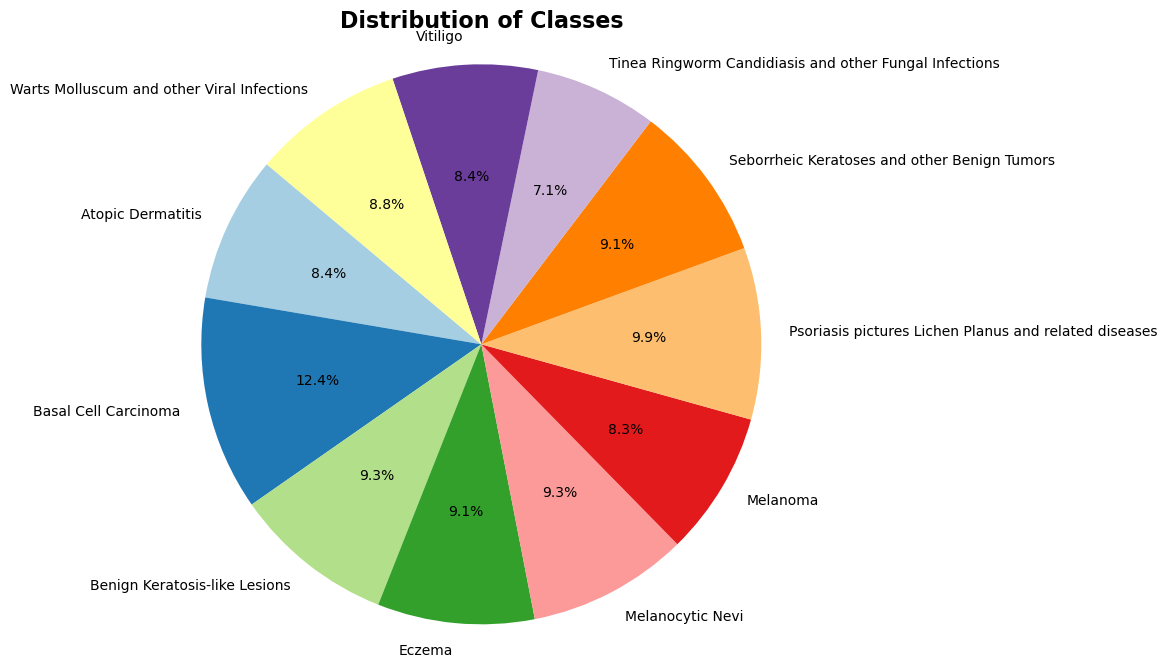

In [64]:
class_counts = [imgDS.targets.count(i) for i in range(len(imgDS.classes))]
# 클래스 이름
class_labels = imgDS.classes

# 파이 그래프 생성
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# 그래프 제목 설정
plt.title('Distribution of Classes', fontsize=16, fontweight='bold')

# 동그라미 형태로 만들기
plt.axis('equal')  

# 그래프 표시
plt.show()

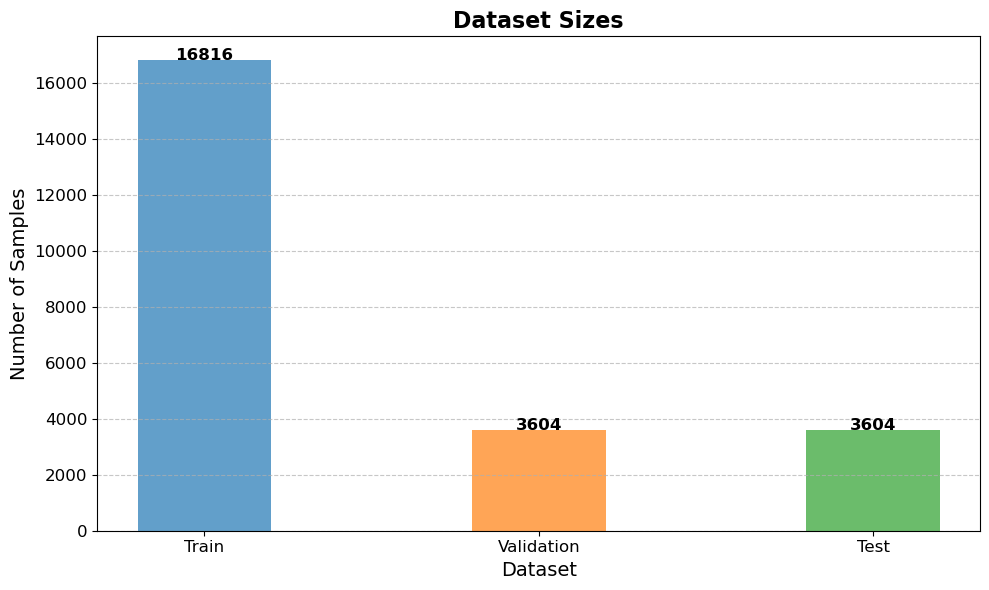

In [47]:
# 각 데이터셋의 크기
train_size = len(train_indices)
val_size = len(val_indices)
test_size = len(test_indices)

# x 좌표 및 데이터 크기 정의
x_labels = ['Train', 'Validation', 'Test']
sizes = [train_size, val_size, test_size]

# 바의 너비
bar_width = 0.4

# 바 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
bars = plt.bar(x_labels, sizes, width=bar_width, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)

# 그래프 제목 및 레이블 설정
plt.title('Dataset Sizes', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# y축 눈금 포맷 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, int(yval), ha='center', fontsize=12, fontweight='bold')

# 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [72]:
tar_num = len(imgDS.classes)
class SkinKitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(32,64,3),
            nn.Conv2d(64,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),                       
        )
        
        self.classifier=nn.Sequential(
            nn.Linear(53*53*32, 512),
            nn.ReLU(),
            nn.Dropout(0.5,inplace=False),
            nn.Linear(512, 256),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.5,inplace=False),
            nn.Linear(128,11)       
        )
        
    def forward(self, data):
        output=self.features(data)
        # print(output.shape)
        output=output.view(output.shape[0], -1)
        return self.classifier(output)

In [66]:
model = SkinKitModel()
# 6. 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. 모델 학습
epochs = 10
patience = 10  # 성능 향상이 없을 때 10번의 에포크 후 학습을 중단

best_loss = float('inf')  # 초기값을 매우 큰 값으로 설정
trigger_times = 0  # 개선되지 않은 에포크 수

In [73]:
LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    train_pred = 0
    for features, targets in train_loader:
        outputs = model(features)
        loss = criterion(outputs, targets)  # float형으로 변환
        outputs_max = torch.max(torch.softmax(outputs,dim=1),dim=1).indices
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        train_pred += f1_score(outputs_max,targets,average='weighted').item()
        

    avg_loss_train = epoch_loss / len(train_loader)
    train_f1 = train_pred / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss_train:.4f}, F1: {train_f1:.4f}')

    LOSS_HISTORY[0].append(avg_loss_train)
    SCORE_HISTORY[0].append(train_f1)

    # 8. 교차검증
    model.eval()
    v_pred = 0
    v_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            outputs_max = torch.max(torch.softmax(outputs,dim=1),dim=1).indices
            v_pred = f1_score(outputs_max,targets,average='weighted').item()
            loss = criterion(outputs, targets)
            v_loss += loss.item()
            
        avg_loss_val = epoch_loss / len(val_loader)
        val_f1 = v_pred / len(val_loader)

        LOSS_HISTORY[1].append(avg_loss_val)
        SCORE_HISTORY[1].append(val_f1)

    # Early Stopping 적용
    if avg_loss_train < best_loss:
        best_loss = avg_loss_train  # 손실이 줄어들면 가장 좋은 손실 업데이트
        trigger_times = 0  # 성능이 개선된 경우 카운트를 초기화
    else:
        trigger_times += 1  # 성능이 개선되지 않은 경우 카운트 증가
        print(f"No improvement in {trigger_times} epochs")
    
    if trigger_times >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # 일정 에포크 동안 개선이 없으면 학습 중단

    if len(SCORE_HISTORY[1]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
        # 모델 전체 저장
        torch.save(model,SAVE_PATH+SAVE_MODEL)
    else:
        if SCORE_HISTORY[1][-1] >= max(SCORE_HISTORY[1]):
            # torch.save(model.state_dict(),f'{SAVE_PATH}{SAVE_FILE}_{epoch}_{LOSS_HISTORY[1][-1]}')
            torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
            # 모델 전체 저장
            torch.save(model,SAVE_PATH+SAVE_MODEL)
            
# 8. 모델 평가
model.eval()
f1 = 0
accuracy = 0

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        outputs_max = torch.max(torch.softmax(outputs,dim=1),dim=1).indices
        f1 += f1_score(outputs_max,targets,average='weighted').item()
        accuracy += accuracy_score(outputs_max, targets).item()
        
    f1 = f1 / len(test_loader)
    accuracy = accuracy / len(test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch [1/10], Loss: 1.9207, F1: 0.3072


PicklingError: Can't pickle <class '__main__.SkinKitModel'>: it's not the same object as __main__.SkinKitModel

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
accuracy_df = pd.DataFrame({'Class': [], 'Accuracy': []})
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        outputs_max = torch.max(torch.softmax(outputs,dim=1),dim=1).indices
        conf_matrix = confusion_matrix(targets, outputs_max)
        # 클래스별 정확도 계산
        class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

        # DataFrame으로 클래스 이름과 정확도를 정리
        class_labels = [f'Class {i}' for i in range(len(class_accuracy))]
        print(class_labels)

        # 정확도가 떨어지는 클래스 출력
        low_accuracy_threshold = 0.2  # 정확도 기준 설정 (예: 50% 이하)
        low_accuracy_classes = accuracy_df[accuracy_df['Accuracy'] < low_accuracy_threshold]

        print("정확도가 떨어지는 클래스:")
        print(low_accuracy_classes)


['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
정확도가 떨어지는 클래스:
Empty DataFrame
Columns: [Class, Accuracy]
Index: []
['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
정확도가 떨어지는 클래스:
Empty DataFrame
Columns: [Class, Accuracy]
Index: []
['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
정확도가 떨어지는 클래스:
Empty DataFrame
Columns: [Class, Accuracy]
Index: []
['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
정확도가 떨어지는 클래스:
Empty DataFrame
Columns: [Class, Accuracy]
Index: []
['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
정확도가 떨어지는 클래스:
Empty DataFrame
Columns: [Class, Accuracy]
Index: []
['Class 0', 'Class 1', 'Class 2', 'Class 3', 

KeyboardInterrupt: 